# Part 03: Find the discontinuities in Seattle's streets
michael babb  
2024 11 24

In [1]:
# standard
import os

In [2]:
# external
from itertools import combinations, product
import geopandas as gpd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import LineString, Point
from shapely import line_merge

In [3]:
# custom
from utils import *

# output

In [4]:
output_file_path = 'H:/project/seattle_streets/data/analysis' 

In [5]:
output_file_name = 'street_analysis.xlsx'

In [6]:
ofpn = os.path.join(output_file_path, output_file_name)

In [7]:
e_writer = pd.ExcelWriter(path = ofpn)

# load the street network data

In [8]:
# file path
input_file_path = 'H:/project/seattle_streets/data/' 

In [9]:
file_name = 'missing_segments.gpkg'

In [10]:
fpn = os.path.join(input_file_path, file_name)

In [11]:
gdf = gpd.read_file(filename = fpn)

In [12]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_stname_concat', 'ord_street_type',
       'ord_street_type_rank', 'snd_group', 'street_status', 'sn_id', 'en_id',
       'dist', 'dist_miles', 'geometry'],
      dtype='object')

In [13]:
gdf['n_segments'] = int(1)

In [14]:
# add text descriptions for the street type categories
missing_dict = {0:'complete_street',
                1:'disconnected_street',
                2:'missing_street'}

In [15]:
gdf['street_status_desc'] = gdf['street_status'].map(missing_dict)

# what street name - excluding direction - has the most street types?

In [16]:
col_names = ['ord_street_name', 'ord_street_type', 'n_segments']

In [17]:
gdf_agg = gdf[col_names].drop_duplicates()

In [18]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['ord_street_type'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [19]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [20]:
gdf_pv.head()

,ord_street_name,AVE,BLVD,BR,CIR,CT,DR,LN,LOOP,MALL,PKWY,PL,PZ,RD,ST,TER,VIEW,WAY,All
0,100TH,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
1,101ST,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
2,102ND,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2
3,103RD,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
4,104TH,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,4


In [21]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 's_type_count', index = False)

# what street name - excluding type - has the most street connections?

In [22]:
col_names = ['ord_street_name', 'ord_stname_concat', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates()

In [23]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['street_status_desc'],
                        aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [24]:
gdf_pv.head()

ord_street_name      n_segments                      \
street_status_desc                 complete_street disconnected_street   
0                            100TH               3                   4   
1                            101ST               3                   2   
2                            102ND               2                   3   
3                            103RD               2                   5   
4                            104TH               4                   4   

                                       
street_status_desc missing_street All  
0                               4  11  
1                               2   7  
2                               3   8  
3                               5  12  
4                               4  12

In [25]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [26]:
gdf_pv.columns

Index(['ord_street_name', 'complete_street', 'disconnected_street',
       'missing_street', 'All'],
      dtype='object')

In [27]:
gdf_pv.head()

,ord_street_name,complete_street,disconnected_street,missing_street,All
0,100TH,3,4,4,11
1,101ST,3,2,2,7
2,102ND,2,3,3,8
3,103RD,2,5,5,12
4,104TH,4,4,4,12


In [28]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_by_name', index = False)

# what street name - include direction and type - has the most street connections?

In [29]:
col_names = ['ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names]

In [30]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = ['ord_stname_concat', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [31]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [32]:
gdf_pv.head()

,ord_stname_concat,ord_street_type,complete_street,disconnected_street,missing_street,All
0,10TH AVE,AVE,0,11,3,14
1,10TH AVE E,AVE,0,21,3,24
2,10TH AVE NE,AVE,7,0,0,7
3,10TH AVE NW,AVE,0,14,4,18
4,10TH AVE S,AVE,0,32,7,39


In [33]:
# remove the all row
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_concat'] != 'All', :]

In [34]:
gdf_pv.shape

(2497, 6)

# what are the streets with at least 10 discontinuities?

In [35]:
gdf_pv.loc[gdf_pv['missing_street'] >= 10, 'ord_stname_concat'].tolist()

['12TH AVE S',
 '16TH AVE S',
 '1ST AVE NW',
 '22ND AVE NE',
 '24TH AVE NE',
 '24TH AVE S',
 '25TH AVE S',
 '26TH AVE NE',
 '27TH AVE S',
 '29TH AVE S',
 '2ND AVE NE',
 '2ND AVE NW',
 '2ND AVE S',
 '30TH AVE S',
 '31ST AVE S',
 '33RD AVE S',
 '35TH AVE S',
 '36TH AVE S',
 '36TH AVE SW',
 '38TH AVE NE',
 '3RD AVE S',
 '44TH AVE SW',
 '45TH AVE S',
 '46TH AVE S',
 '46TH AVE SW',
 '4TH AVE NE',
 '8TH AVE S',
 'CORLISS AVE N',
 'DENSMORE AVE N',
 'PALATINE AVE N',
 'S BENNETT ST',
 'S HINDS ST',
 'S RAYMOND ST',
 'S ROSE ST',
 'W RAYE ST']

In [36]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_full_name', index = False)

In [37]:
# number of streets with at least one missing segment
split_streets = gdf_pv.loc[gdf_pv['disconnected_street'] > 0, :].shape[0]
split_streets

1140

In [38]:
# number of streets with no missing segments
complete_streets = gdf_pv.loc[gdf_pv['complete_street'] > 0, :].shape[0]
complete_streets

1357

In [39]:
split_streets / gdf_pv.shape[0]

0.4565478574289147

In [40]:
complete_streets / gdf_pv.shape[0]

0.5434521425710853

In [41]:
# 46 percent of streets are multi-segments.
# 54 percent of streets are single segment.

# sum of road miles by disconnected street

In [42]:
col_names = ['ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'dist_miles']
gdf_agg = gdf[col_names]

In [43]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['dist_miles'], index = ['ord_stname_concat', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [44]:
gdf_pv.columns = [''.join(cn).replace('dist_miles', '') for cn in gdf_pv.columns]

In [45]:
gdf_pv.shape

(2498, 6)

In [46]:
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_concat']!= 'All', :].copy()

In [47]:
gdf_pv.shape

(2497, 6)

In [48]:
gdf_pv.head()

,ord_stname_concat,ord_street_type,complete_street,disconnected_street,missing_street,All
0,10TH AVE,AVE,0.00000,0.613528,0.328426,0.941954
1,10TH AVE E,AVE,0.00000,1.942426,0.051903,1.994328
2,10TH AVE NE,AVE,0.48567,0.000000,0.000000,0.485670
3,10TH AVE NW,AVE,0.00000,1.701021,1.753063,3.454084
4,10TH AVE S,AVE,0.00000,2.025667,4.517775,6.543441


In [49]:
# WHICH STREETS FEATURE LONGER DISCONNECTED PORTIONS?
gdf_pv['longer_missing'] = int(0) # street is complete
gdf_pv.loc[(gdf_pv['complete_street'] == 0) & (gdf_pv['missing_street'] <= gdf_pv['disconnected_street']), 'longer_missing'] = int(1)
gdf_pv.loc[(gdf_pv['complete_street'] == 0) & (gdf_pv['missing_street'] > gdf_pv['disconnected_street']), 'longer_missing'] = int(2)

In [50]:
gdf_pv['longer_missing'].value_counts()

longer_missing
0    1357
1     840
2     300
Name: count, dtype: int64

In [51]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'distance_full_name', index = False)

In [52]:
# road miles on streets with at least one missing segment
split_streets = gdf_pv['disconnected_street'].sum()
split_streets

1511.0745079236742

In [53]:
# road miles on streets with no missing segments
complete_streets = gdf_pv['complete_street'].sum()
complete_streets

420.9508936253788

In [54]:
split_streets / (split_streets + complete_streets)

0.7821193793374196

In [55]:
complete_streets / (split_streets + complete_streets)

0.2178806206625804

In [56]:
# 78 percent of road miles are multi-segments streets
# 22 percent of road miles are single segment streets

# tabulate distances and distributions by street type

In [57]:
st_type_df = pd.pivot_table(data = gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()



In [58]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [59]:
st_type_df.shape

(17, 4)

In [60]:
st_type_df.head()

,ord_street_type,complete_street,disconnected_street,missing_street
0,AVE,111.130081,828.215079,436.939922
1,BLVD,11.388519,13.867313,0.662671
2,BR,13.147350,0.000000,0.000000
3,CIR,0.704074,0.000000,0.000000
4,CT,4.442460,0.228902,0.066143


In [61]:
# now, melt
st_type_df_melt = pd.melt(frame = st_type_df, id_vars = ['ord_street_type'],
                          var_name = 'street_status_desc',
                          value_name = 'total_miles')

In [62]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,complete_street,111.130081
1,BLVD,complete_street,11.388519
2,BR,complete_street,13.147350
3,CIR,complete_street,0.704074
4,CT,complete_street,4.442460


In [63]:
col_names = ['ord_street_type', 'street_status_desc', 'dist_miles']

In [64]:
ds_st_df = gdf[col_names].groupby(col_names[:-1]).describe().reset_index()

In [65]:
ds_st_df.head()

ord_street_type   street_status_desc dist_miles                      \
                                            count      mean       std   
0             AVE      complete_street     1484.0  0.074885  0.046680   
1             AVE  disconnected_street    10345.0  0.080059  0.048284   
2             AVE       missing_street     1806.0  0.241938  0.390708   
3            BLVD      complete_street      115.0  0.099031  0.090999   
4            BLVD  disconnected_street      130.0  0.106672  0.092032   

                                                     
        min       25%       50%       75%       max  
0  0.002083  0.049255  0.066940  0.088289  0.639583  
1  0.000947  0.049960  0.068181  0.122227  0.633067  
2  0.002857  0.030976  0.091495  0.256562  3.739595  
3  0.006818  0.051247  0.068698  0.106965  0.605102  
4  0.002317  0.055406  0.082050  0.132516  0.697001

In [66]:
ds_st_df.columns =  [''.join(cn).replace('dist_miles', '') for cn in ds_st_df.columns]

In [67]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,complete_street,1484.0,0.074885,0.046680,0.002083,0.049255,0.066940,0.088289,0.639583
1,AVE,disconnected_street,10345.0,0.080059,0.048284,0.000947,0.049960,0.068181,0.122227,0.633067
2,AVE,missing_street,1806.0,0.241938,0.390708,0.002857,0.030976,0.091495,0.256562,3.739595
3,BLVD,complete_street,115.0,0.099031,0.090999,0.006818,0.051247,0.068698,0.106965,0.605102
4,BLVD,disconnected_street,130.0,0.106672,0.092032,0.002317,0.055406,0.082050,0.132516,0.697001


In [68]:
temp_ds_st_df = ds_st_df.loc[ds_st_df['street_status_desc'] == 'missing_street', :].copy()

In [69]:
temp_ds_st_df = temp_ds_st_df.drop(labels = 'std', axis = 1)

In [70]:
temp_ds_st_df = temp_ds_st_df.sort_values(by = ['count'], ascending = False)

In [71]:
temp_ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'missing_street_count', index = False)

In [72]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,complete_street,111.130081
1,BLVD,complete_street,11.388519
2,BR,complete_street,13.147350
3,CIR,complete_street,0.704074
4,CT,complete_street,4.442460


In [73]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,complete_street,1484.0,0.074885,0.046680,0.002083,0.049255,0.066940,0.088289,0.639583
1,AVE,disconnected_street,10345.0,0.080059,0.048284,0.000947,0.049960,0.068181,0.122227,0.633067
2,AVE,missing_street,1806.0,0.241938,0.390708,0.002857,0.030976,0.091495,0.256562,3.739595
3,BLVD,complete_street,115.0,0.099031,0.090999,0.006818,0.051247,0.068698,0.106965,0.605102
4,BLVD,disconnected_street,130.0,0.106672,0.092032,0.002317,0.055406,0.082050,0.132516,0.697001


In [74]:
# join to get total miles and summary statistics
ds_st_df = pd.merge(left = st_type_df_melt, right = ds_st_df, how = 'left')

In [75]:
ds_st_df.head()

,ord_street_type,street_status_desc,total_miles,count,mean,std,min,25%,50%,75%,max
0,AVE,complete_street,111.130081,1484.0,0.074885,0.046680,0.002083,0.049255,0.066940,0.088289,0.639583
1,BLVD,complete_street,11.388519,115.0,0.099031,0.090999,0.006818,0.051247,0.068698,0.106965,0.605102
2,BR,complete_street,13.147350,74.0,0.177667,0.154664,0.004735,0.057955,0.127488,0.241951,0.689962
3,CIR,complete_street,0.704074,15.0,0.046938,0.050546,0.005492,0.014464,0.036020,0.065051,0.204545
4,CT,complete_street,4.442460,86.0,0.051657,0.030255,0.002273,0.028444,0.048578,0.066217,0.156602


In [76]:
ds_st_df.columns

Index(['ord_street_type', 'street_status_desc', 'total_miles', 'count', 'mean',
       'std', 'min', '25%', '50%', '75%', 'max'],
      dtype='object')

In [77]:
for cn in ds_st_df.columns:
    if ds_st_df[cn].dtype == 'float64':
        ds_st_df[cn] = ds_st_df[cn].fillna(0)

In [78]:
ds_st_df = ds_st_df.sort_values(by = ['ord_street_type', 'street_status_desc'])

In [79]:
ds_st_df['street_status_desc'] = ds_st_df['street_status_desc'].str.replace('_street', '')

In [80]:
# set index

In [81]:
ds_st_df = ds_st_df.set_index(keys = ['ord_street_type', 'street_status_desc'])

In [82]:
# reorder columns
col_names = ['count', 'min', '25%', '50%', 'mean', '75%', 'max', 'total_miles']
ds_st_df = ds_st_df[col_names]

In [83]:
ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'sum_stats', index = True)
                  

In [84]:
e_writer.close()

In [85]:
ds_st_df.head()

count       min       25%       50%  \
ord_street_type street_status_desc                                          
AVE             complete             1484.0  0.002083  0.049255  0.066940   
                disconnected        10345.0  0.000947  0.049960  0.068181   
                missing              1806.0  0.002857  0.030976  0.091495   
BLVD            complete              115.0  0.006818  0.051247  0.068698   
                disconnected          130.0  0.002317  0.055406  0.082050   

                                        mean       75%       max  total_miles  
ord_street_type street_status_desc                                             
AVE             complete            0.074885  0.088289  0.639583   111.130081  
                disconnected        0.080059  0.122227  0.633067   828.215079  
                missing             0.241938  0.256562  3.739595   436.939922  
BLVD            complete            0.099031  0.106965  0.605102    11.388519  
                disconnected        0.106672  0.132516  0.697001    13.867313

# 10 longest missing streets

In [86]:
wms_gdf = gdf.loc[gdf['street_status'] == 2, :].copy()

In [87]:
wms_gdf['dist_rank'] = wms_gdf['dist'].rank(method = 'dense', ascending = False)

In [88]:
wms_gdf.loc[wms_gdf['dist_rank'] <= 10, 'ord_stname_concat'].tolist()

['S 112TH ST',
 'S 106TH ST',
 '20TH AVE S',
 '11TH AVE S',
 '33RD AVE SW',
 'S 105TH ST',
 '9TH AVE S',
 'S 116TH ST',
 '7TH PL S',
 'S 108TH ST']

# histogram of all added streets

In [89]:
# log transform the distance in miles to prep for plotting
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [90]:
wms_gdf['dist_miles_log'].describe()

count    3643.000000
mean       -1.024413
std         0.577650
min        -3.128428
25%        -1.486670
50%        -1.075904
75%        -0.601155
max         0.696677
Name: dist_miles_log, dtype: float64

In [91]:
# compute summary stats and create a dataframe
# the ds_df will hold values of interest to plot and plotting keywords for 
# those values
ds_df = wms_gdf['dist_miles'].describe().to_frame().reset_index(names = ['stat'])

In [92]:
# remove the count and the standard deviation - not useful for plotting
ds_df = ds_df.loc[-ds_df['stat'].isin(['count', 'std']), :]

In [93]:
# add the 10th, 95th, and 99th precentiles
temp_stat_records = [
    ['10%', np.quantile(a = wms_gdf['dist_miles'], q = 0.10)],
    ['95%', np.quantile(a = wms_gdf['dist_miles'], q = 0.95)],
    ['99%', np.quantile(a = wms_gdf['dist_miles'], q = 0.99)]
]
temp_stat_df = pd.DataFrame(data = temp_stat_records, columns = ds_df.columns)
temp_stat_df.head()

,stat,dist_miles
0,10%,0.018747
1,95%,0.962718
2,99%,1.797078


In [94]:
# combine
ds_df = pd.concat(objs = [ds_df, temp_stat_df], axis = 0)

In [95]:
ds_df = ds_df.sort_values(by = ['dist_miles'])

In [96]:
ds_df['dist_miles_log'] = ds_df['dist_miles'].map(lambda x: np.log10(x))

In [97]:
# the color of the lines to add
ds_df['color_list'] = 'black'

In [98]:
# convert to feet to help with labeling
ds_df['dist_feet'] = ds_df['dist_miles'] * 5280

In [99]:
# this the horizontal alignment of each piece of added text
ds_df['text_ha'] = ['left', 'right',  'center', 'right', 'right', 'left', 'center', 'center', 'right']

In [100]:
# the text labels to add
ds_df['text'] = ['4ft (min.)', '99 ft (10%)', '172 ft (25%)', '443 ft (med.)', '0.23 mi (avg.)', '0.25 mi (75%)', '0.96 mi (95%)','1.8 mi (99%)', '5 mi (max.)']

In [101]:
# jitter each piece of text by a small amount left or right
ds_df['text_jitter'] = [0, .001, 0, .09, 0, 0, -.05, 0, 0]

In [102]:
# the horizontal position is created from the distance in miles and the text jitter
ds_df['text_x_pos'] = ds_df['dist_miles_log'] + ds_df['text_jitter']

In [103]:
ds_df.head(n=10)

,stat,dist_miles,dist_miles_log,color_list,dist_feet,text_ha,text,text_jitter,text_x_pos
3,min,0.000744,-3.128428,black,3.928314,left,4ft (min.),0.000,-3.128428
0,10%,0.018747,-1.727074,black,98.982774,right,99 ft (10%),0.001,-1.726074
4,25%,0.032608,-1.486670,black,172.172750,center,172 ft (25%),0.000,-1.486670
5,50%,0.083964,-1.075904,black,443.332350,right,443 ft (med.),0.090,-0.985904
1,mean,0.228895,-0.640363,black,1208.567839,right,0.23 mi (avg.),0.000,-0.640363
6,75%,0.250521,-0.601155,black,1322.752385,left,0.25 mi (75%),0.000,-0.601155
1,95%,0.962718,-0.016501,black,5083.153075,center,0.96 mi (95%),-0.050,-0.066501
2,99%,1.797078,0.254567,black,9488.573933,center,1.8 mi (99%),0.000,0.254567
7,max,4.973674,0.696677,black,26261.000182,right,5 mi (max.),0.000,0.696677


..\assets\_all_streets_dist_histogram.png


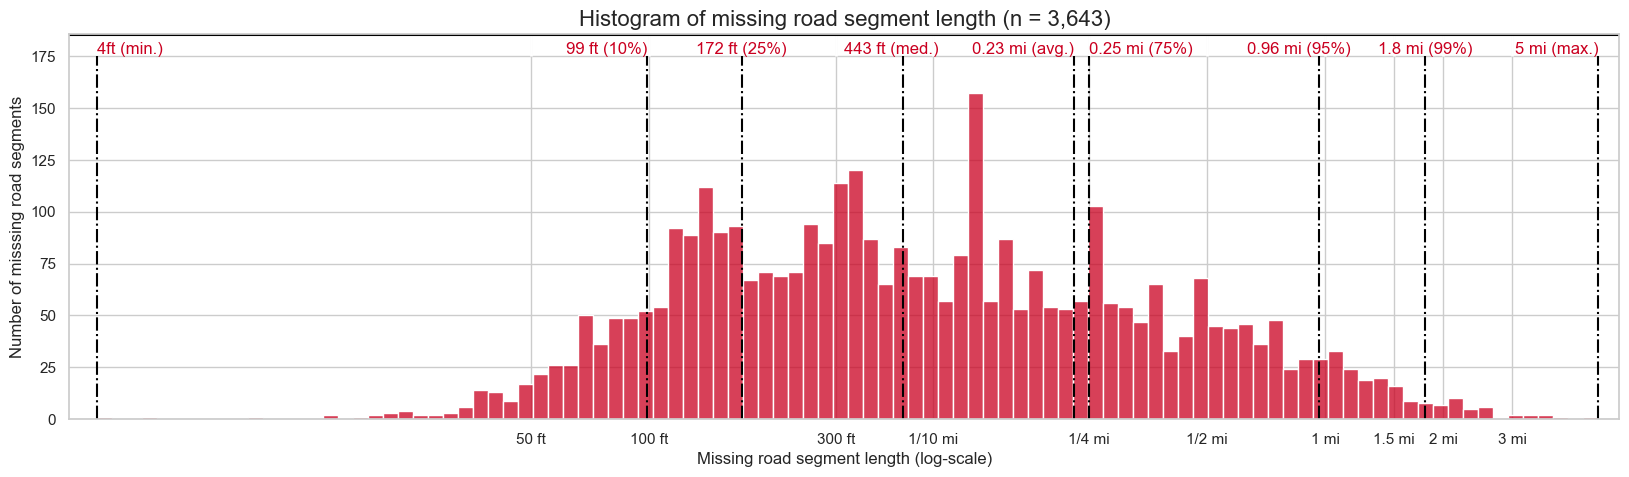

In [104]:
# compute the histogram of the added distribution
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)
ax.set_xlim(-3.2, .75)

my_plot = sns.histplot(data = wms_gdf, x = 'dist_miles_log',
                      color='#ca0020', bins = 100)

y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# total missing streets
n_missing = wms_gdf.shape[0]
n_missing =  f"{n_missing:,}"

plt.title(label = "Histogram of missing road segment length (n = {})".format(n_missing), fontsize = 16)
plt.xlabel(xlabel = 'Missing road segment length (log-scale)')
plt.ylabel(ylabel = "Number of misssing road segments")

# x tick positions
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 1.5, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '1.5 mi', '2 mi', '3 mi']


my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# white out the top portion of the ticks
for xt in x_ticks:
    my_plot.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = ds_df['dist_miles_log'], ymin = 0, ymax = 175, color = ds_df['color_list'], linestyles = 'dashdot')

# add text for the descriptive stats
for ir, row in ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 176, s = row['text'], horizontalalignment = row['text_ha'], color = '#ca0020')

my_plot.hlines(y = 185, xmin = -3.2, xmax = 1, colors = 'black')

output_file_name = '..\\assets\\_all_streets_dist_histogram.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [105]:
# and there you have it... most added streets are very short. 
# 75% of all added streets are 0.25 miles or less. 

# histogram of each type of street

In [106]:
st_type_df = pd.pivot_table(data = wms_gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()

In [107]:
st_type_df.head()

,ord_street_type,dist_miles
street_status_desc,,missing_street
0,AVE,436.939922
1,BLVD,0.662671
2,CT,0.066143
3,DR,1.527658
4,LN,2.171834


In [108]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [109]:
st_type_df.head()

,ord_street_type,missing_street
0,AVE,436.939922
1,BLVD,0.662671
2,CT,0.066143
3,DR,1.527658
4,LN,2.171834


In [110]:
st_type_df.columns = ['ord_street_type', 'total_miles']

In [111]:
ds_df = wms_gdf[['ord_street_type', 'dist_miles']].groupby(['ord_street_type'])['dist_miles'].describe().reset_index(names = ['ord_street_type'])

In [112]:
ds_df.head()

,ord_street_type,count,mean,std,min,25%,50%,75%,max
0,AVE,1806.0,0.241938,0.390708,0.002857,0.030976,0.091495,0.256562,3.739595
1,BLVD,13.0,0.050975,0.069432,0.001021,0.013328,0.030070,0.046605,0.255118
2,CT,2.0,0.033072,0.020849,0.018329,0.025700,0.033072,0.040443,0.047814
3,DR,19.0,0.080403,0.088947,0.004334,0.030876,0.057824,0.081903,0.383551
4,LN,13.0,0.167064,0.279788,0.014486,0.018194,0.031653,0.068437,0.903147


In [113]:
ds_df['max'].tolist()

[3.7395953497001355,
 0.25511811226877146,
 0.04781399100785158,
 0.3835505539397646,
 0.9031467790728132,
 0.015428321856929715,
 4.97367427687857,
 0.44164899742250396,
 4.048921545671539,
 0.8421779354619497]

In [114]:
ds_df.shape

(10, 9)

In [115]:
for ir, row in ds_df.iterrows():
    # let's make a graphic showing the distances
    sns.set_theme(style = "whitegrid")
    f, ax = plt.subplots(figsize = (20, 5))

    x_max = row['max']
    ost = row['ord_street_type']
    
    #ax.set_ylim(0, 185.6)
    if x_max > 1:
        xlim_max = .75
    else:
        xlim_max = 0
    ax.set_xlim(-3.2, xlim_max)

    temp_gdf = wms_gdf.loc[wms_gdf['ord_street_type'] == ost, :]
    my_plot = sns.histplot(data = temp_gdf, x = 'dist_miles_log',
                          color='#ca0020', bins = 100)
    
    #y_ticks = list(range(0, 176, 25))
    #y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   
    
    #my_plot.set_yticks(ticks = y_ticks)
    #my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)
    
    # total missing streets
    n_missing = temp_gdf.shape[0]
    n_missing =  f"{n_missing:,}"
    
    plt.title(label = "Histogram of missing road segment length: {} (n = {})".format(row['ord_street_type'], n_missing), fontsize = 16)
    plt.xlabel(xlabel = 'Missing road segment  length (log-scale)')
    plt.ylabel(ylabel = "Number of misssing road segments")
    
    if x_max > 1:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 1.5, 2, 3]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '1.5 mi', '2 mi', '3 mi']
    else:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi']
        
    x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
    #print(len(x_ticks))    
    #print(len(x_tick_label_text))
    
    my_plot.set_xticks(ticks = x_ticks)
    my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)
    
    # white out the top portion of the ticks
    #for xt in x_ticks:
    #    my_plot.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)
    
    # add vertical lines at some descriptive statistics points
    #my_plot.vlines(x = ds_df['dist_miles_log'], ymin = 0, ymax = 175, color = ds_df['color_list'], linestyles = 'dashdot')
    
    # add text for the descriptive stats
    #for ir, row in ds_df.iterrows():
    #    my_plot.text(x = row['text_x_pos'], y = 176, s = row['text'], horizontalalignment = row['text_ha'], color = '#ca0020')
    
    #my_plot.hlines(y = 185, xmin = -3.2, xmax = 1, colors = 'black')
    
    output_file_name = '..\\assets\\{}_dist_histogram.png'.format(row['ord_street_type'])
    output_file_name = os.path.normpath(output_file_name)
    print(output_file_name)
    my_plot.get_figure().savefig(fname = output_file_name)
    plt.close()

..\assets\AVE_dist_histogram.png
..\assets\BLVD_dist_histogram.png
..\assets\CT_dist_histogram.png
..\assets\DR_dist_histogram.png
..\assets\LN_dist_histogram.png
..\assets\PKWY_dist_histogram.png
..\assets\PL_dist_histogram.png
..\assets\RD_dist_histogram.png
..\assets\ST_dist_histogram.png
..\assets\WAY_dist_histogram.png
